In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('chest_xray_predictions.csv')

In [ ]:
df.columns.to_list()

['filename',
 'true_label',
 'gpt_4o_response',
 'gpt_41_response',
 'gemini_response',
 'claude_response',
 'grok_response']

In [ ]:
llm_col_list = [
 'gpt_4o_response',
 'gpt_41_response',
 'gemini_response',
 'claude_response',
 'grok_response']

In [ ]:
df['true_label'] = df['true_label'].replace({0: 'Normal', 1: 'Bacterial Pneumonia'})
for col in llm_col_list:
    df[col] = df[col].replace({0: 'Normal', 1: 'Bacterial Pneumonia'})

In [ ]:
df.head()

,filename,true_label,gpt_4o_response,gpt_41_response,gemini_response,claude_response,grok_response
0,NORMAL2-IM-1056-0001.jpeg,Normal,Bacterial Pneumonia,Normal,Bacterial Pneumonia,Bacterial Pneumonia,Bacterial Pneumonia
1,NORMAL2-IM-1260-0001.jpeg,Normal,Bacterial Pneumonia,Normal,Bacterial Pneumonia,Bacterial Pneumonia,Bacterial Pneumonia
2,IM-0656-0001-0001.jpeg,Normal,Bacterial Pneumonia,Normal,Bacterial Pneumonia,Bacterial Pneumonia,Normal
3,NORMAL2-IM-1110-0001.jpeg,Normal,Bacterial Pneumonia,Bacterial Pneumonia,Bacterial Pneumonia,Bacterial Pneumonia,Bacterial Pneumonia
4,IM-0757-0001.jpeg,Normal,Bacterial Pneumonia,Normal,Normal,Bacterial Pneumonia,Normal


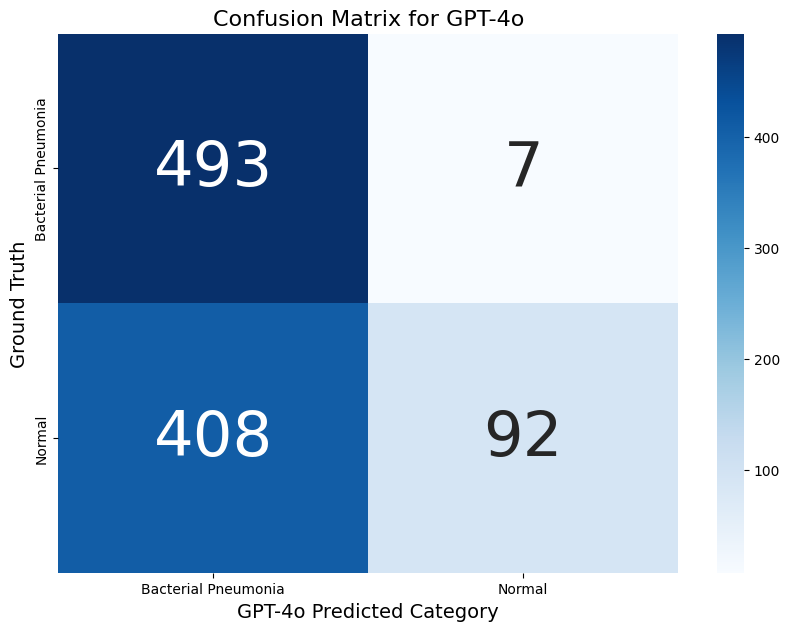

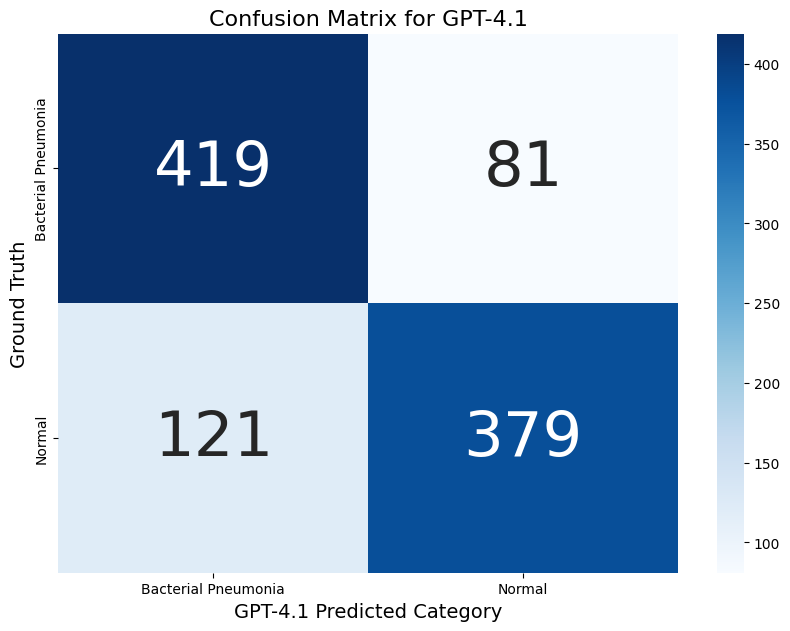

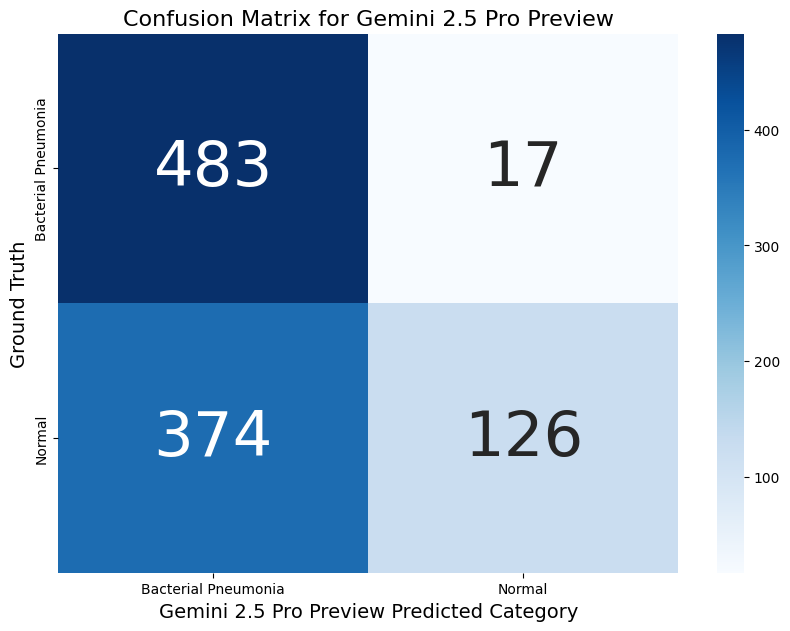

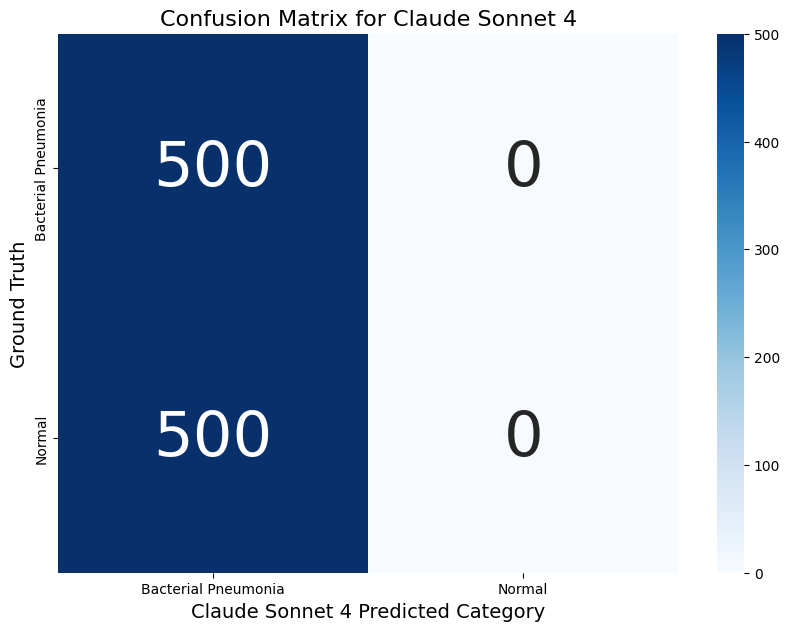

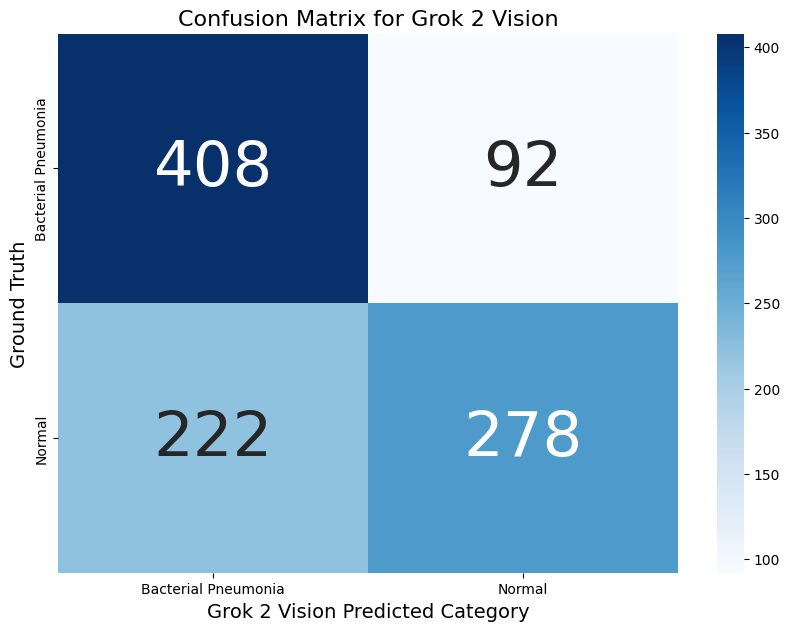

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df.rename(columns={
    'true_label':'Actual Category',
    'gpt_4o_response':'GPT-4o Predicted Category',
    'gpt_41_response':'GPT-4.1 Predicted Category',
    'gemini_response':'Gemini 2.5 Pro Preview Predicted Category',
    'claude_response':'Claude Sonnet 4 Predicted Category',
    'grok_response':'Grok 2 Vision Predicted Category'
    },inplace=True)

df['Actual Category'] = df['Actual Category'].astype(str)

llm_col_list = [
    'GPT-4o Predicted Category',
    'GPT-4.1 Predicted Category',
    'Gemini 2.5 Pro Preview Predicted Category',
    'Claude Sonnet 4 Predicted Category',
    'Grok 2 Vision Predicted Category'
    ]

for col in llm_col_list:
    df[col] = df[col].astype(str)

actual = df['Actual Category']
for col in llm_col_list:
    pred =  df[col]
    df_confusion = pd.crosstab(actual, pred)
    df_confusion = df_confusion.reindex(index=['Bacterial Pneumonia', 'Normal'],
                                        columns=['Bacterial Pneumonia', 'Normal']
                                        ).fillna(0).astype(int)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_confusion, annot=True, fmt='d', cmap='Blues',annot_kws={"size": 45})
    title = col.replace(' Predicted Category', '')
    plt.title(f'Confusion Matrix for {title}', fontsize=16)
    plt.xlabel(col , fontsize=14)
    plt.ylabel('Ground Truth', fontsize=14)
    plt.show()


In [ ]:
# Function to calculate metrics
def calculate_metrics(TP, TN, FP, FN):
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Specificity": specificity
    }

classes = sorted(actual.unique())

# Loop through each model's predictions
for col in llm_col_list:
    print(f'\n=== Metrics for {col.replace(" Predicted Category", "")} ===\n')
    pred = df[col]
    cm = confusion_matrix(actual, pred, labels=classes)

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        metrics = calculate_metrics(TP, TN, FP, FN)

        print(f"Metrics for {cls}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
        print()









=== Metrics for GPT-4o ===

Metrics for Bacterial Pneumonia:
Accuracy: 0.5850
Precision: 0.5472
Recall: 0.9860
F1-Score: 0.7038
Specificity: 0.1840

Metrics for Normal:
Accuracy: 0.5850
Precision: 0.9293
Recall: 0.1840
F1-Score: 0.3072
Specificity: 0.9860


=== Metrics for GPT-4.1 ===

Metrics for Bacterial Pneumonia:
Accuracy: 0.7980
Precision: 0.7759
Recall: 0.8380
F1-Score: 0.8058
Specificity: 0.7580

Metrics for Normal:
Accuracy: 0.7980
Precision: 0.8239
Recall: 0.7580
F1-Score: 0.7896
Specificity: 0.8380


=== Metrics for Gemini 2.5 Pro Preview ===

Metrics for Bacterial Pneumonia:
Accuracy: 0.6090
Precision: 0.5636
Recall: 0.9660
F1-Score: 0.7119
Specificity: 0.2520

Metrics for Normal:
Accuracy: 0.6090
Precision: 0.8811
Recall: 0.2520
F1-Score: 0.3919
Specificity: 0.9660


=== Metrics for Claude Sonnet 4 ===

Metrics for Bacterial Pneumonia:
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667
Specificity: 0.0000

Metrics for Normal:
Accuracy: 0.5000
Precision: 0.

In [ ]:
from sklearn.metrics import classification_report

for col in llm_col_list:
    pred = df[col]
    print(f"\n=== Classification Report for {col.replace(' Predicted Category', '')} ===\n")
    print(classification_report(actual, pred, target_names=classes, digits=4))


=== Classification Report for GPT-4o ===

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.5472    0.9860    0.7038       500
             Normal     0.9293    0.1840    0.3072       500

           accuracy                         0.5850      1000
          macro avg     0.7382    0.5850    0.5055      1000
       weighted avg     0.7382    0.5850    0.5055      1000


=== Classification Report for GPT-4.1 ===

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.7759    0.8380    0.8058       500
             Normal     0.8239    0.7580    0.7896       500

           accuracy                         0.7980      1000
          macro avg     0.7999    0.7980    0.7977      1000
       weighted avg     0.7999    0.7980    0.7977      1000


=== Classification Report for Gemini 2.5 Pro Preview ===

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.5636    0.9660    0.7119    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


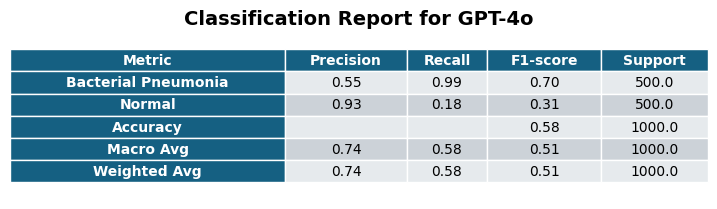

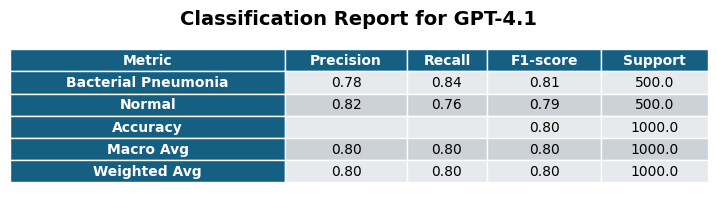

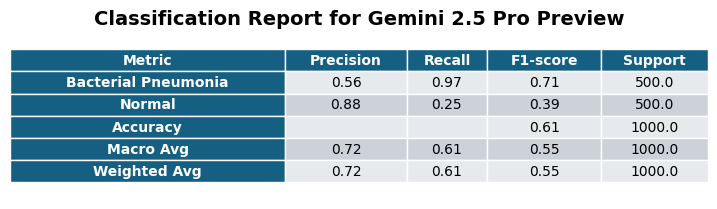

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


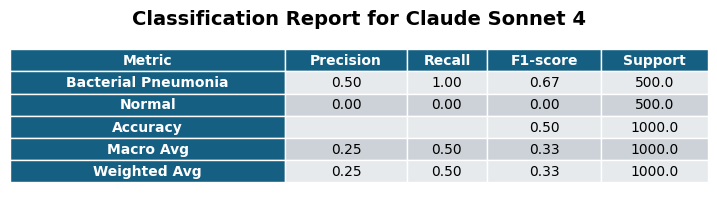

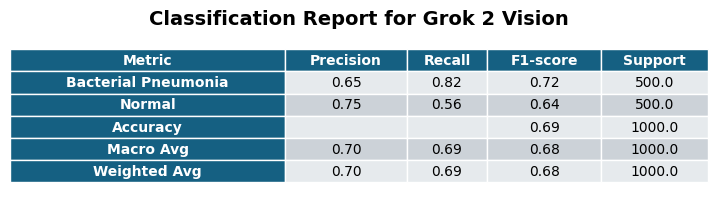

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

llm_col_list = [
    'GPT-4o Predicted Category',
    'GPT-4.1 Predicted Category',
    'Gemini 2.5 Pro Preview Predicted Category',
    'Claude Sonnet 4 Predicted Category',
    'Grok 2 Vision Predicted Category'
]

# Define class order
classes = sorted(actual.unique())

for col in llm_col_list:
    # Get predictions and classification metrics
    pred = df[col]
    report = classification_report(actual, pred, target_names=classes, output_dict=True)

    # Extract and structure the table data
    rows = []
    for cls in classes:
        rows.append([
            cls,
            "{:.2f}".format(report[cls]['precision']),
            "{:.2f}".format(report[cls]['recall']),
            "{:.2f}".format(report[cls]['f1-score']),
            int(report[cls]['support'])
        ])

    rows.append(["Accuracy", "", "", "{:.2f}".format(report['accuracy']), sum(report[cls]['support'] for cls in classes)])
    rows.append(["Macro Avg",
                "{:.2f}".format(report['macro avg']['precision']),
                "{:.2f}".format(report['macro avg']['recall']),
                "{:.2f}".format(report['macro avg']['f1-score']),
                int(report['macro avg']['support'])])
    rows.append(["Weighted Avg",
                "{:.2f}".format(report['weighted avg']['precision']),
                "{:.2f}".format(report['weighted avg']['recall']),
                "{:.2f}".format(report['weighted avg']['f1-score']),
                int(report['weighted avg']['support'])])

    # Convert to DataFrame
    table_df = pd.DataFrame(rows, columns=["Metric", "Precision", "Recall", "F1-score", "Support"])

    # Plot table
    fig, ax = plt.subplots(figsize=(9, len(rows) * 0.45))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=table_df.values,
                 colLabels=table_df.columns,
                 cellLoc='center',
                 bbox=[0, 0.1, 1, 0.8])

    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(table_df.columns))))

    for (row, cell_col), cell in table.get_celld().items():
      cell.set_edgecolor('white')
      if row == 0:
          cell.set_facecolor('#156082')
          cell.set_text_props(color='white', weight='bold')
      elif cell_col == 0:
          cell.set_facecolor('#156082')
          cell.set_text_props(color='white', weight='bold')
      elif row % 2 == 0:
          cell.set_facecolor('#CCD2D8')
      else:
          cell.set_facecolor('#E6EAED')

    plt.title(f"Classification Report for {col.replace(' Predicted Category', '')}", fontsize=14, weight='bold')
    plt.subplots_adjust(top=0.85)
    plt.show()

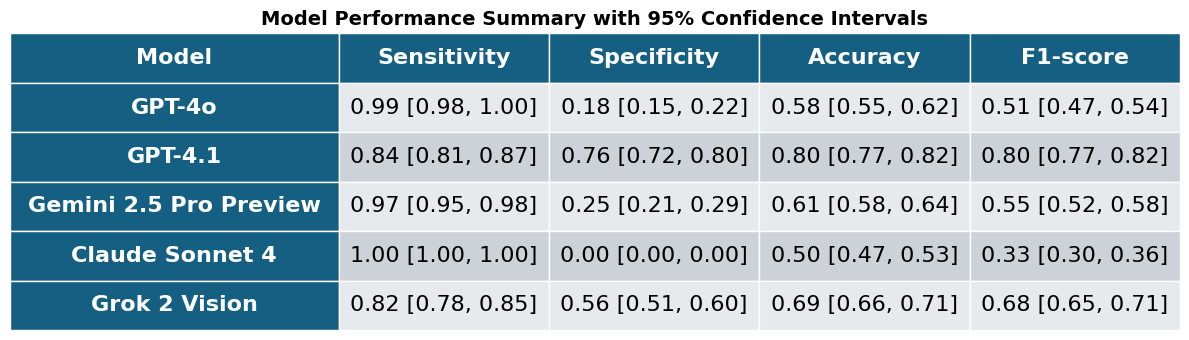

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

# List of model prediction columns
llm_col_list = [
    'GPT-4o Predicted Category',
    'GPT-4.1 Predicted Category',
    'Gemini 2.5 Pro Preview Predicted Category',
    'Claude Sonnet 4 Predicted Category',
    'Grok 2 Vision Predicted Category'
]

# Class order (assumes binary classification)
classes = sorted(actual.unique())
positive_class = 'Bacterial Pneumonia'
negative_class = 'Normal'

# Function to compute confidence interval for proportion
def ci_prop(p, n, z=1.96):
    se = np.sqrt(p * (1 - p) / n)
    return max(0, p - z * se), min(1, p + z * se)

# Final summary table rows
summary_rows = []

for col in llm_col_list:
    pred = df[col]
    cm = confusion_matrix(actual, pred, labels=classes)

    TP = cm[0, 0]
    FN = cm[0, 1]
    FP = cm[1, 0]
    TN = cm[1, 1]

    total = TP + TN + FP + FN

    # Metrics
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / total
    f1 = f1_score(actual, pred, average='weighted')

    # CIs
    sens_ci = ci_prop(sensitivity, TP + FN)
    spec_ci = ci_prop(specificity, TN + FP)
    acc_ci = ci_prop(accuracy, total)
    f1_ci = ci_prop(f1, total)  # Approximated denominator for f1

    summary_rows.append([
        col.replace(' Predicted Category', ''),
        f"{sensitivity:.2f} [{sens_ci[0]:.2f}, {sens_ci[1]:.2f}]",
        f"{specificity:.2f} [{spec_ci[0]:.2f}, {spec_ci[1]:.2f}]",
        f"{accuracy:.2f} [{acc_ci[0]:.2f}, {acc_ci[1]:.2f}]",
        f"{f1:.2f} [{f1_ci[0]:.2f}, {f1_ci[1]:.2f}]"
    ])

# Create the final DataFrame
summary_df = pd.DataFrame(summary_rows, columns=["Model", "Sensitivity", "Specificity", "Accuracy", "F1-score"])

# Plot table
fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.7))
ax.axis('off')

table = ax.table(cellText=summary_df.values,
                 colLabels=summary_df.columns,
                 cellLoc='center',
                 bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(16)
table.auto_set_column_width(col=list(range(len(summary_df.columns))))

for (row, cell_col), cell in table.get_celld().items():
    cell.set_edgecolor('white')
    if row == 0:
        cell.set_facecolor('#156082')
        cell.set_text_props(color='white', weight='bold')
    elif cell_col == 0:
        cell.set_facecolor('#156082')
        cell.set_text_props(color='white', weight='bold')
    elif row % 2 == 0:
        cell.set_facecolor('#CCD2D8')
    else:
        cell.set_facecolor('#E6EAED')

plt.title("Model Performance Summary with 95% Confidence Intervals", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
